# Classification

preliminary operations

In [1]:
# from google.colab import files # in order to be able to download and upload files

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import torchvision

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix

import os
from tqdm.notebook import tqdm

from collections import OrderedDict

import optuna
import noise
import plotly

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # solving a bug of colab.

In [3]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}: {torch.cuda.get_device_name(0)}")

Training device: cuda: GeForce GTX 960M


## Datasets

In [4]:
# get the datasets

all_train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True)
all_test_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True)

raw = True

In [5]:
val_perc = 0.2
shuffle = False

tr_list, val_list = train_test_split(all_train_dataset,test_size=val_perc, shuffle=shuffle) # create training and validation datasets

test_list = [sample for sample in all_test_dataset]

print(len(tr_list), len(val_list), len(test_list))

48000 12000 10000


In [ ]:
class ListDataset(Dataset):
  '''
  Args:
    data_list: list with the data
    transform (callable, optional): Optional transform to be applied on a sample.
  '''
  def __init__(self, data_list, transform=None):
    self.transform = transform
    self.data = data_list

  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    sample = self.data[idx]
    if self.transform:
      sample = self.transform(sample)
    return sample

### Transforms

In [ ]:
class ToTensor():
  '''
  Convert to tensor the image
  '''
  def __init__(self):
    self.t = transforms.ToTensor()

  def __call__(self, sample):
    pic, label = sample
    sample = (self.t(pic), label)
    return sample


# useful if we want to use MSE loss
class OneHotEncoder():
    '''
    Convert each encoded character in "sample" in a one-hot representation.
    INPUT
      e.g. 7
    OUTPUT
      ...0001000000 # all zeros but 1 at position 7.
    '''
    
    def __init__(self, alphabet_len):
      self.alphabet_len = alphabet_len
        
    def __call__(self, sample):
      pic, label = sample

      ### Create one hot matrix
      onehot = np.zeros(self.alphabet_len)
      onehot[label] = 1.

      sample = (pic, torch.tensor(onehot).float())
      return sample

ohe = OneHotEncoder(10)

In [ ]:
train_transform = transforms.Compose([
    ToTensor(),
])
mse_transform = transforms.Compose([
    ToTensor(),
    ohe,
])

In [ ]:
if raw:
  all_train_dataset = ListDataset([sample for sample in all_train_dataset], train_transform)
  raw = False

train_dataset = ListDataset(tr_list, train_transform)
val_dataset = ListDataset(val_list, train_transform)
test_dataset = ListDataset(test_list, train_transform)

## Evolver

In [ ]:
class Evolver(object):
  '''
  Class for evolving the Network. This class is a starting point: to do more advanced stuff one can define new classes inheriting from this one.

  Args:
    net
    optimizer: needs to be already linked to the net
    loss_function
    train_dataloader: training Dataloader
    val_dataloader: validation Dataloader
  '''
  def __init__(self, net, optimizer, loss_function, train_dataloader, val_dataloader):
    self.net = net
    self.optimizer = optimizer
    self.loss_function = loss_function

    self.train_dataloader = train_dataloader
    self.val_dataloader = val_dataloader

    self.train_loss_log = []
    self.val_loss_log = []


  def stop_learning(self,epoch_num):
    return False


  def train_epoch(self):
    train_loss= []
    self.net.train() # Training mode
    for sample_batched in self.train_dataloader:
      # Move data to device
      x_batch = sample_batched[0].to(device)
      label_batch = sample_batched[1].to(device)
      # set previous gradients to 0
      self.optimizer.zero_grad()
      # Forward pass
      out = self.net(x_batch)
      # Compute loss
      loss = self.loss_function(out,label_batch)
      # Backpropagation
      loss.backward()
      # Update the weights
      self.optimizer.step()

      # Save train loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      train_loss.append(loss_batch)

    # Save average train loss
    train_loss = np.mean(train_loss)
    return train_loss

  def val_epoch(self,dl):
    '''
    Args:
      dl: Dataloader on which to perform the test
    '''
    val_loss= []
    self.net.eval() # Evaluation mode
    with torch.no_grad(): # Disable gradient tracking
      for sample_batched in dl:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)
        # Forward pass
        out = self.net(x_batch)
        # Compute loss
        loss = self.loss_function(out,label_batch)
        # Save val loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        val_loss.append(loss_batch)

      # Save average validation loss
      val_loss = np.mean(val_loss)
      return val_loss

  def evolve(self,num_epochs,verbose=False):

    ### TRAINING LOOP
    for epoch_num in tqdm(np.arange(num_epochs) + len(self.train_loss_log)):
      if verbose:
        print('#################')
        print(f'# EPOCH {epoch_num}')

      ### TRAIN
      train_loss = self.train_epoch()
      if verbose:
        print(f"AVERAGE TRAIN LOSS: {train_loss}")
      self.train_loss_log.append(train_loss)

      ### VALIDATION
      val_loss = self.val_epoch(self.val_dataloader)
      if verbose:
        print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
      self.val_loss_log.append(val_loss)

      if self.stop_learning(epoch_num):
        break
        

  def plot_losses(self,avg_size=10):
    '''
    Plots the behavior of the train and val losses and prints their average in the last 'avg_size' epochs
    Args:
      avg_size: int
    '''
    plt.figure(figsize=(12,8))
    plt.semilogy(self.train_loss_log, label='Training loss')
    plt.semilogy(self.val_loss_log, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    plt.show()

    print('Average traininig  loss in the last %d epochs: %.4f' %(avg_size, np.mean(self.train_loss_log[-avg_size:])))
    print('Average validation loss in the last %d epochs: %.4f' %(avg_size, np.mean(self.val_loss_log[-avg_size:])))


  def test(self,test_dataset):
    '''
    Args:
      test_dataset: Dataset with data on which to perform the test
    '''
    test_dataloader = DataLoader(test_dataset,batch_size=256,shuffle=False,num_workers=0)
    return self.val_epoch(test_dataloader)

#### Early stopping

In [ ]:
class Evolver_es(Evolver):

  def __init__(self, patience, checkpoint=False, *args, **kwargs):
    '''
    Args:
      patience: int: if after patience peochs the validation loss does not decrease learning stops
      checkpoint: bool: if True when learning stops the net is checkpointed back to when the validation loss was at its minimum

      *args, **kwargs: arguments of the parent class
    '''
    super().__init__(*args, **kwargs)

    self.patience = patience
    self.counter = 0
    self.best_vl = 10
    self.checkpoint = checkpoint
    self.net_checkpoint = None
    self.optim_checkpoint = None

  def stop_learning(self,epoch_num):
    if epoch_num <= self.patience: # at least do 'patience' epochs
      return False

    if self.val_loss_log[-1] < self.best_vl:
      self.best_vl = self.val_loss_log[-1]
      self.counter = 0
      if self.checkpoint:
        self.net_checkpoint = (epoch_num, self.net.state_dict())
        self.optim_checkpoint = self.optimizer.state_dict()
    else:
      self.counter += 1

    if self.counter >= self.patience:
      if self.checkpoint:
        print(f'Checkpointing back to epoch {self.net_checkpoint[0]}')
        self.net.load_state_dict(self.net_checkpoint[1])
        self.optimizer.load_state_dict(self.optim_checkpoint)
        self.train_loss_log = self.train_loss_log[:self.net_checkpoint[0] + 1]
        self.val_loss_log = self.val_loss_log[:self.net_checkpoint[0] + 1]
      return True
    return False

## Fully connected network

In [ ]:
class FC_net(nn.Module):
  def __init__(self, Ni, Nh1, Nh2, No, activation_function=nn.ReLU(), o_act=nn.Identity()):
    '''
    Network with 2 hidden linear layers
    '''
    super().__init__()

    self.flatten = nn.Flatten(start_dim=1)

    self.fc1 = nn.Linear(in_features=Ni,out_features=Nh1)
    self.fc2 = nn.Linear(in_features=Nh1,out_features=Nh2)
    self.out = nn.Linear(in_features=Nh2,out_features=No)

    self.act = activation_function
    self.o_act = o_act

    print('Network initialized')

  def forward(self, x):

    x = self.flatten(x)
    x = self.act(self.fc1(x))
    x = self.act(self.fc2(x))
    x = self.o_act(self.out(x)) # use a sigmoid to force the output layer to have values between 0 and 1

    return x

### Training

In [ ]:
Ni = 28*28
Nh1 = 128
Nh2 = 16
No = 10
activation_function = nn.ReLU()
o_act = nn.Identity()

# torch.manual_seed(0)

net = FC_net(Ni,Nh1,Nh2,No,activation_function=activation_function, o_act=o_act).to(device)

optimizer = optim.Adam(net.parameters(),lr=0.001,weight_decay=0)

loss_function = nn.CrossEntropyLoss()

train_batch_size = 256
val_batch_size = 256

patience = 10

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=0)


nature = Evolver_es(patience=patience,net=net,optimizer=optimizer,loss_function=loss_function,
                    train_dataloader=train_dataloader,val_dataloader=val_dataloader)

In [ ]:
nature.evolve(40,verbose= False)

nature.plot_losses()

### Test with MSE loss

0 tensor(8.4598e-12, device='cuda:0')
1 tensor(5.6049e-08, device='cuda:0')
2 tensor(1., device='cuda:0')
3 tensor(3.2895e-09, device='cuda:0')
4 tensor(8.1808e-15, device='cuda:0')
5 tensor(1.3672e-14, device='cuda:0')
6 tensor(2.5442e-09, device='cuda:0')
7 tensor(9.0259e-13, device='cuda:0')
8 tensor(3.8709e-12, device='cuda:0')
9 tensor(1.7942e-16, device='cuda:0')
loss = 3.158837587915298e-16


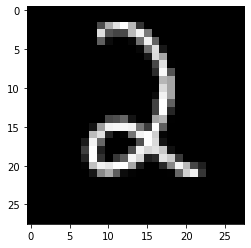

In [ ]:
# test on one sample
test_dataset.transform = test_transform
net.o_act = nn.Softmax(dim=1)

idx = 47

sample = test_dataset[idx]

pic, label = sample

pic = pic.to(device)
label = label.to(device)

net.eval()
with torch.no_grad():
  y = net(pic)

  # loss = nature.loss_function(y,torch.tensor([label]).to(device))
  # loss = nn.NLLLoss()(y,torch.tensor([6]))
  loss = nn.MSELoss()(y,label.unsqueeze(0))

for i,v in enumerate(y.squeeze()):
  print(i,v)

print(f'loss = {loss}')


plt.figure()
plt.imshow(np.array(pic.squeeze().cpu()), cmap='gist_gray')

We can use avg_test_loss/max_mseloss to quantify the percentage of wrongly classified test samples

In [ ]:
def mse_test(evolver, test_dataset):
  '''
  Computes the MSE loss on a test dataset, automaticaaly setting the proper transforms and activations
  Args:
    evolver
    test_dataset
  
  Returns:
    mse_accuracy = 1 - mse_loss/max_mse_loss
  '''
  tt = test_dataset.transform
  o_act = evolver.net.o_act
  lf = evolver.loss_function

  test_dataset.transform = mse_transform
  test_dataloader = DataLoader(test_dataset,batch_size=256,shuffle=False,num_workers=0)

  evolver.net.o_act = nn.Softmax(dim=1)
  evolver.loss_function = nn.MSELoss()
  try:
    avg_test_loss = evolver.val_epoch(test_dataloader)
    mse_accuracy = (1 - float(avg_test_loss/max_mseloss))
  except:
    print('Mismatched shapes')
    mse_accuracy = None

  # revert everything back to how it was
  test_dataset.transform = tt
  evolver.net.o_act = o_act
  evolver.loss_function = lf

  return mse_accuracy


s1 = 1, 0
s2 = 1, 1

_, l1 = ohe(s1)
_, l2 = ohe(s2)

max_mseloss = nn.MSELoss()(l1,l2)
min_mseloss = nn.MSELoss()(l1,l1)
print(f'MSELoss() in [{min_mseloss}, {max_mseloss}]')

In [ ]:
mse_test(nature, test_dataset)

### Test with accuracy and confusion matrix

In [ ]:
def evaluate_net(net, test_dataset):
  '''
  Computes confusion matrix and accuracy
  Args:
    net
    test_dataset
  
  Returns:
    confusion_matrix: pd.DataFrame
    accuracy = fraction of correctly classified samples
  '''
  test_dataloader = DataLoader(test_dataset,batch_size=256,shuffle=False,num_workers=0)

  net_outputs = np.array([])
  labels = np.array([])

  net.eval()
  with torch.no_grad():
    for batch in test_dataloader:
      out = torch.argmax(net(batch[0].to(device)), dim=1).cpu().numpy()
      # print(out.shape)
      label = batch[1].squeeze().cpu().numpy()

      net_outputs = np.concatenate([net_outputs, out])
      labels = np.concatenate([labels, label])

  net_outputs = np.array(net_outputs, dtype=int)
  labels = np.array(labels, dtype=int)

  cm_df = pd.DataFrame(data=confusion_matrix(labels, net_outputs))
  accuracy = np.mean(net_outputs == labels)

  return cm_df, accuracy

In [ ]:
evaluate_net(net,test_dataset)

### Visualizing the net

#### Weights of the first layer

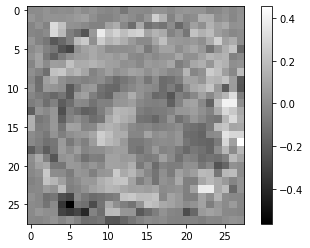

In [ ]:
# testing

neuron_idx = 0

unflattener = nn.Unflatten(0,(28,28))

ws = net.fc1.weight.detach().cpu()[neuron_idx]
ws = unflattener(ws)

plt.figure()
plt.imshow(ws.numpy(), cmap='gist_gray')
plt.colorbar()

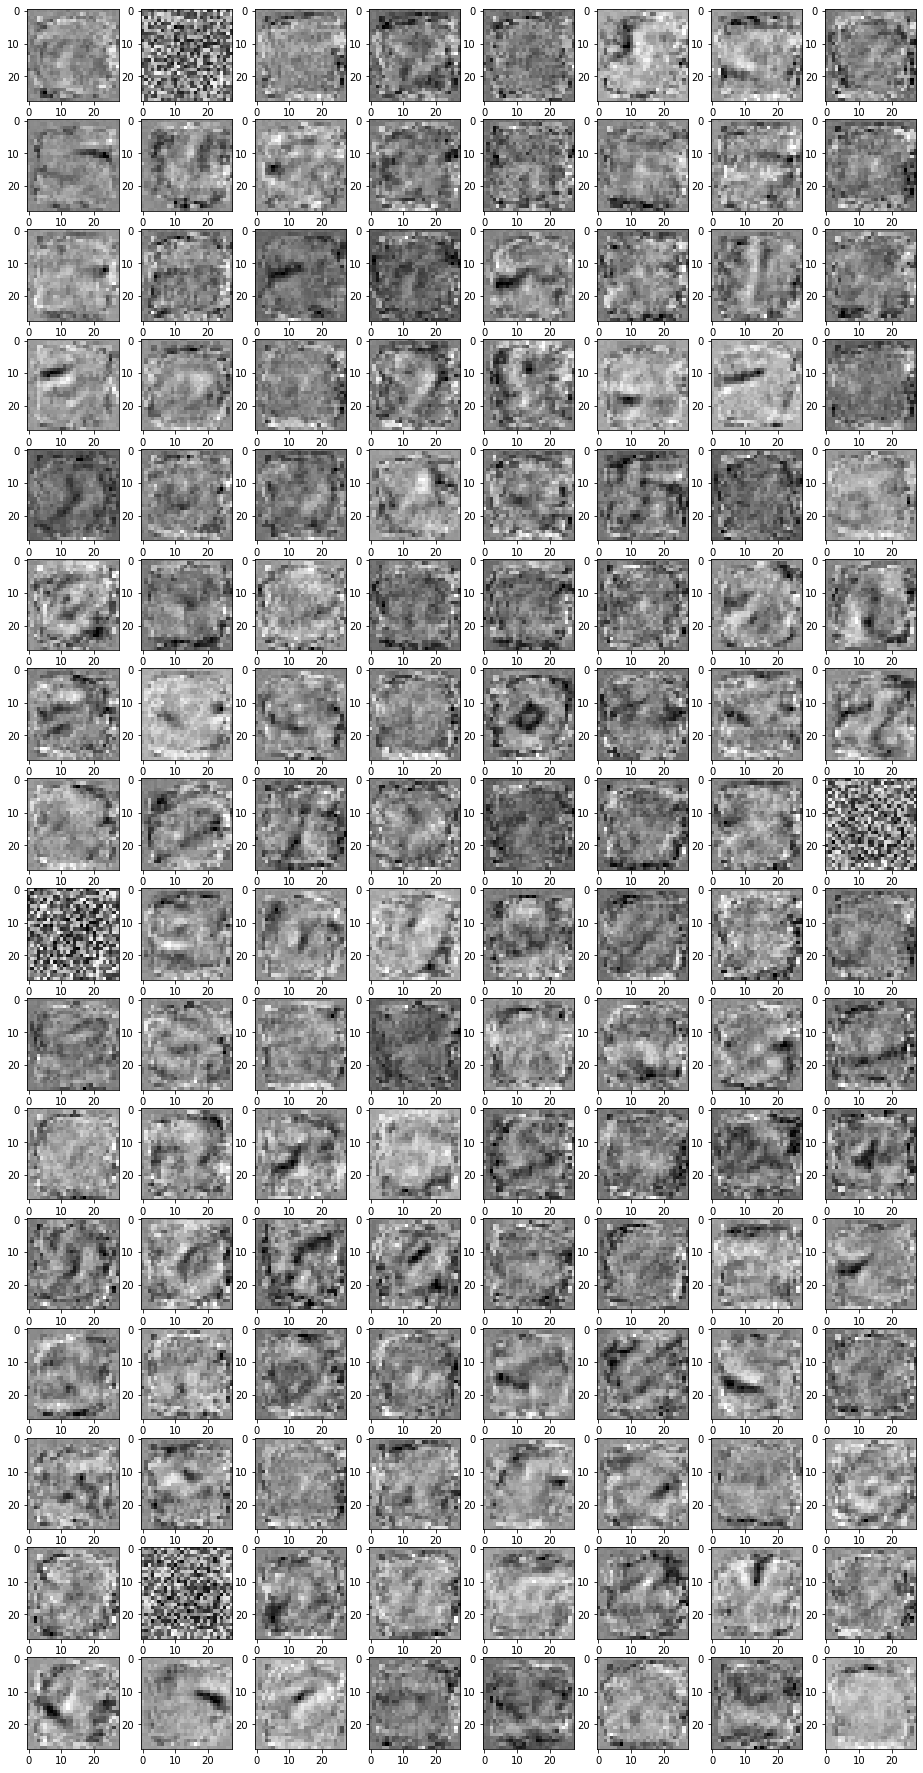

In [ ]:
fig, axs = plt.subplots(nrows = 16, ncols = 8,figsize=(16,32))

for i in range(16):
  for j in range(8):

    neuron_idx = 8*i + j

    ws = net.fc1.weight.detach().cpu()[neuron_idx]
    ws = unflattener(ws)
    axs[i,j].imshow(ws.numpy(), cmap='gist_gray')

#### Input that maximally activates a neuron

In [ ]:
class NeuronMaximizer():
  '''
  Class for finding the input that maximally activates a specific neuron of a net

  Args:
    net
    layer: layer of the net where the neuron is, e.g. net.out
    neuron_idx: int, index of the neuron in the layer
    optimizer_type: default otpim.Adam
    optimizer_params: dictionary with the parameters for the optimizer
    other_neurons_penalty: float, default 0.
      The optimizer will minimize -(activation of the neuron) + other_neurons_penalty*sum(activation of the other neurons in the layer)
  '''
  def __init__(self, net, layer, neuron_idx=0, optimizer_type=optim.Adam, optimizer_params={'lr': 0.01, 'weight_decay': 0}, other_neurons_penalty=0):
    self.net = net
    self.layer = layer
    self.neuron_idx = neuron_idx
    self.activation = None
    self.input_img = torch.zeros((1,28,28),requires_grad=True, device=device)
    self.optimizer = optimizer_type([self.input_img], **optimizer_params)
    self.other_neurons_penalty = other_neurons_penalty

  def get_activation(self, layer, input, output):
    self.activation = output

  def optimize(self,iterations=50, verbose=True, show_imgs=True, show_colorbar=False):
    hook_handle = self.layer.register_forward_hook(self.get_activation)

    for i in range(iterations):
      if verbose:
        print(f'### iteration {i}:')

      # normalize the image to avoid simply increasing the contrast
      norm_img = torch.sigmoid(self.input_img).unsqueeze(0)
      # print(norm_img.size())

      self.optimizer.zero_grad()
      y = self.net(norm_img)

      if show_imgs:
        plt.figure()
        plt.imshow(norm_img.squeeze().cpu().detach().numpy(), cmap='gist_gray', vmin=0, vmax=1)
        plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
        if show_colorbar:
          plt.colorbar()

      act = -self.activation[0, self.neuron_idx]
      if self.other_neurons_penalty != 0:
        act += self.other_neurons_penalty*(torch.sum(self.activation[0]) - self.activation[0, self.neuron_idx])

      if verbose:
        print(f'activation = {-act.cpu().detach().numpy()}')

      act.backward(retain_graph=True)
      self.optimizer.step()

    hook_handle.remove()

In [ ]:
nm = NeuronMaximizer(net,net.out,9,optimizer_params={'lr':0.1, 'weight_decay': 0.01})
nm.optimize(iterations=80)

In [ ]:
y = torch.softmax(net(torch.sigmoid(nm.input_img)), dim=1)

y = y.squeeze().detach().cpu().numpy()

for i,yv in enumerate(y):
  print(f'{i}: {yv}')

## Convolutional network

In [ ]:
class C_net(nn.Module):
  '''
  Convolutional neural network
  '''

  def __init__(self, channels=[], kernel_sizes=[], strides=[], paddings=[], Nhs=[], activation_function=nn.ReLU, No=10, o_act=nn.Identity()):
    '''
    Params of the convolutional layers: the following should be lists of int and be of the same lenght
      channels
      kernel_sizes
      strides
      paddings

    Params of the linear layers:
      Nhs: list of int: numbers of neurons per linear layer
      No: number of output neurons
    
    Activation functions:
      activation_function: default nn.ReLU (beware NOT nn.ReLU()): activation function between all the hidden layers
      o_act: default nn.Identity(): activation function after the output layer
    '''
    super().__init__()

    self.shapes = [(1, 28, 28)]

    ### Convolutional layer

    ## Create an ordered dictionary with the layers
    self.conv_od = OrderedDict([])
    for i,c in enumerate(channels):
      # add convolutional layer
      if i == 0:
        self.conv_od.update({'conv1': nn.Conv2d(in_channels=1,out_channels=channels[0],
                                                       kernel_size=kernel_sizes[0], stride = strides[0], padding=paddings[0])})
      else:
        self.conv_od.update({f'conv{i + 1}': nn.Conv2d(in_channels=channels[i - 1],out_channels=c,
                                                       kernel_size=kernel_sizes[i], stride = strides[i], padding=paddings[i])})
      self.shapes.append((c, self.shapes[-1][1]//strides[i], self.shapes[-1][2]//strides[i]))
      # add activation function
      self.conv_od.update({f'conv_act{i + 1}': activation_function()})

    ## Create a sequential layer
    self.conv_layers = nn.Sequential(self.conv_od)


    ### Flatten

    self.flatten = nn.Flatten(start_dim=1)
    self.shapes.append(np.product(self.shapes[-1]))


    ### Linear fc layers

    ## Create ordered dictionary with the layers
    self.lin_od = OrderedDict([])
    Nhs = [self.shapes[-1]] + Nhs
    for i in range(1,len(Nhs)):
      # add linear layer
      self.lin_od.update({f'lin{i}': nn.Linear(in_features=Nhs[i - 1], out_features=Nhs[i])})
      self.shapes.append(Nhs[i])

      # add activation function
      self.lin_od.update({f'lin_act{i}': activation_function()})

    ## Create a sequential layer
    self.lin_layers = nn.Sequential(self.lin_od)


    ## Create the output layer
    self.out = nn.Linear(in_features=Nhs[-1], out_features=No)
    self.o_act = o_act

    print('Network initialized')

  def forward(self, x):
    # apply convolutional layers
    x = self.conv_layers(x)

    # flatten
    x = self.flatten(x)

    # apply linear layers
    x = self.lin_layers(x)

    # output layer
    x = self.o_act(self.out(x))
    return x

In [ ]:
# testing
channels = [8,16,32]
kernel_sizes = [3,3,3]
strides = [2,2,2]
paddings = [1,1,0]

Nhs = [128, 16]

cnet = C_net(channels=channels, kernel_sizes=kernel_sizes, strides=strides, paddings=paddings,
             Nhs=Nhs).to(device)

optimizer = optim.Adam(cnet.parameters(),lr=0.001,weight_decay=1e-4)

loss_function = nn.CrossEntropyLoss()

train_batch_size = 256
val_batch_size = 256

patience = 10

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=0)


nature = Evolver_es(patience=patience,net=cnet,optimizer=optimizer,loss_function=loss_function,
                    train_dataloader=train_dataloader,val_dataloader=val_dataloader, checkpoint=True)

In [ ]:
nature.evolve(40,verbose= False)

nature.plot_losses()

### Test using MSE loss

In [ ]:
mse_test(nature, test_dataset)

### Test with accuracy and confusion matrix

In [ ]:
cnet.o_act = nn.Identity()

test_dataset.transform = train_transform
test_dataloader = DataLoader(test_dataset,batch_size=256,shuffle=False,num_workers=0)

net_outputs = np.array([])
labels = np.array([])

cnet.eval()
with torch.no_grad():
  for batch in test_dataloader:
    out = torch.argmax(cnet(batch[0].to(device)), dim=1).cpu().numpy()
    # print(out.shape)
    label = batch[1].squeeze().cpu().numpy()

    net_outputs = np.concatenate([net_outputs, out])
    labels = np.concatenate([labels, label])

net_outputs = np.array(net_outputs, dtype=int)
labels = np.array(labels, dtype=int)

In [ ]:
evaluate_net(cnet, test_dataset)

### Visualizing the net

#### input that maximally activates a neuron

In [ ]:
print(cnet)

C_net(
  (conv_layers): Sequential(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_act1): ReLU()
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_act2): ReLU()
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (conv_act3): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin_layers): Sequential(
    (lin1): Linear(in_features=288, out_features=128, bias=True)
    (lin_act1): ReLU()
    (lin2): Linear(in_features=128, out_features=16, bias=True)
    (lin_act2): ReLU()
  )
  (out): Linear(in_features=16, out_features=10, bias=True)
  (o_act): Identity()
)


In [ ]:
nm = NeuronMaximizer(cnet, cnet.out, 5, optimizer_params={'lr':0.1, 'weight_decay':0.01})
nm.optimize(iterations=80)

In [ ]:
y = torch.softmax(cnet(torch.sigmoid(nm.input_img).unsqueeze(0)), dim=1)

y = y.squeeze().detach().cpu().numpy()

for i,yv in enumerate(y):
  print(f'{i}: {yv}')

#### Feature space analysis

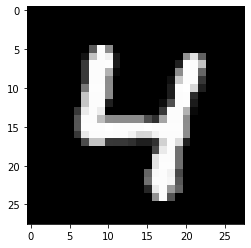

In [ ]:
idx = 56

pic = test_dataset[idx][0].unsqueeze(0).to(device)

plt.figure()
plt.imshow(np.array(pic.squeeze().cpu()), cmap='gist_gray')

In [ ]:
print(cnet)

C_net(
  (conv_layers): Sequential(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_act1): ReLU()
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_act2): ReLU()
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (conv_act3): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin_layers): Sequential(
    (lin1): Linear(in_features=288, out_features=128, bias=True)
    (lin_act1): ReLU()
    (lin2): Linear(in_features=128, out_features=16, bias=True)
    (lin_act2): ReLU()
  )
  (out): Linear(in_features=16, out_features=10, bias=True)
  (o_act): Softmax(dim=None)
)


In [ ]:
def get_acts(layer, input, output):
  print(layer)
  acts.append(output)

hook_handles = []

layer = cnet.conv_layers.conv_act1
hook_handles.append(layer.register_forward_hook(get_acts))
# hook_handles.append(cnet.conv_layers.conv_act2.register_forward_hook(get_activation))
# hook_handles.append(cnet.conv_layers.conv_act3.register_forward_hook(get_activation))

In [ ]:
def plot_nchw_data(data, h_num=None, v_num=None, title=None):
    shape = data.shape
    data = data.reshape(shape[0]*shape[1], shape[2], shape[3])
    if h_num is None or v_num is None:
      n = shape[0]*shape[1]
      h_num = int(np.sqrt(n)) + 1
      v_num = n//h_num + 1
    # print(h_num, v_num)
    fig, axs = plt.subplots(v_num, h_num, figsize=(h_num,v_num))
    for idx, ax in enumerate(axs.flatten()):
        ax.set_xticks([])
        ax.set_yticks([])
        if idx < len(data):
            ax.imshow(data[idx,:,:], cmap='gray')
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.97], h_pad=0, w_pad=0)
    plt.show()

In [ ]:
for a in acts:
  print(a.size())

In [ ]:
# Evaluate output
cnet.eval()
with torch.no_grad():
    acts = []
    out = cnet(pic)

# Analyze intermediate outputs
for layer_num, act in enumerate(acts):
    act = act.cpu().data.numpy()
    # Plot
    plot_nchw_data(act, title='Layer %d convolutional kernels' % (layer_num + 1))

In [ ]:
for hook_handle in hook_handles:
  hook_handle.remove()

### Advanced methods

#### Dropout

In [ ]:
class DC_net(C_net):
  '''
  Adds a Dropout layer before every hidden fully connected layer
  '''

  def __init__(self, *args, dropouts_probabilities=[], **kwargs):
    super().__init__(**kwargs)
    
    self.d_od = OrderedDict()

    i = 0
    for k,l in self.lin_od.items():
      if not k.startswith('lin_act') and i < len(dropouts_probabilities):
        self.d_od.update({f'dropout{i+1}': nn.Dropout(dropouts_probabilities[i])})
        i += 1
      self.d_od.update({k: l})

    self.lin_layers = nn.Sequential(self.d_od)

In [ ]:
channels = [8,16,32]
kernel_sizes = [3,3,3]
strides = [2,2,2]
paddings = [1,1,0]

dropout_probabilities = [0.5,0.5]
Nhs = [128, 16]

dnet = DC_net(dropouts_probabilities=dropout_probabilities,channels=channels, kernel_sizes=kernel_sizes, strides=strides, paddings=paddings,
             Nhs=Nhs).to(device)

print(dnet)

optimizer = optim.Adam(dnet.parameters(),lr=0.001,weight_decay=1e-4)

loss_function = nn.CrossEntropyLoss()

train_batch_size = 256
val_batch_size = 256

patience = 10

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=0)


nature = Evolver_es(patience=patience,net=dnet,optimizer=optimizer,loss_function=loss_function,
                    train_dataloader=train_dataloader,val_dataloader=val_dataloader, checkpoint=True)

Network initialized
DC_net(
  (conv_layers): Sequential(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_act1): ReLU()
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_act2): ReLU()
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (conv_act3): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin_layers): Sequential(
    (dropout1): Dropout(p=0.5, inplace=False)
    (lin1): Linear(in_features=288, out_features=128, bias=True)
    (lin_act1): ReLU()
    (dropout2): Dropout(p=0.5, inplace=False)
    (lin2): Linear(in_features=128, out_features=16, bias=True)
    (lin_act2): ReLU()
  )
  (out): Linear(in_features=16, out_features=10, bias=True)
  (o_act): Identity()
)


In [ ]:
nature.evolve(100,verbose= False)

nature.plot_losses()

In [ ]:
mse_test(nature, test_dataset)

In [ ]:
evaluate_net(dnet,test_dataset)

In [ ]:
dnet.eval()
nm = NeuronMaximizer(dnet,dnet.out,9,optimizer_params={'lr': 0.1, 'weight_decay': 0.01})
nm.optimize(100)

In [ ]:
y = torch.softmax(dnet(torch.sigmoid(nm.input_img).unsqueeze(0)), dim=1)

y = y.squeeze().detach().cpu().numpy()

for i,yv in enumerate(y):
  print(f'{i}: {yv}')

#### Perlin noise

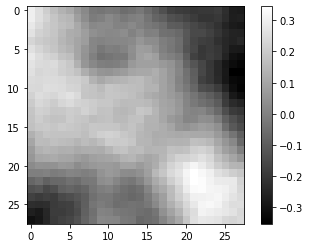

In [ ]:
pic = np.zeros((28,28))

x_t = np.random.uniform(0, 1024)
y_t = np.random.uniform(0, 1024)

for i,row in enumerate(pic):
  for j, pixel in enumerate(row):
    pic[i,j] = noise.pnoise2(i/28 + x_t,j/28 + y_t, octaves=8, persistence=0.5, lacunarity=2)
plt.figure()
plt.imshow(pic, cmap='gist_gray')
plt.colorbar()

In [ ]:
class Perlin():
  def __init__(self, shape=(28,28), p=0.1, saturation=10, pnoise_kwargs={'octaves': 8, 'persistence': 0.5, 'lacunarity': 2}):
    self.shape = shape
    self.p = p
    self.saturation = saturation
    self.pnoise_kwargs = pnoise_kwargs
    self.vpnoise = np.vectorize(self._vpnoise)
    self.x = None
    self.y = None
    self.x,self.y = np.meshgrid(np.arange(self.shape[0])/self.shape[0], np.arange(self.shape[0])/self.shape[0])
    self.x = self.x.flatten()
    self.y = self.y.flatten()

  def _vpnoise(self,x,y):
    return noise.pnoise2(x,y,**self.pnoise_kwargs)

  def create_image(self):
    x_t = np.random.uniform(0,1024)
    y_t = np.random.uniform(0,1024)

    img = self.vpnoise(self.x + x_t, self.y + y_t).reshape(self.shape)

    # convert to tensor
    img = torch.tensor(img).float().unsqueeze(0)
    #saturate the image
    img = torch.sigmoid(self.saturation*img)
    return img

  def __call__(self,sample):
    if np.random.uniform(0,1) < self.p:
      sample = (self.create_image(), 10)

    else:
      pic, label = sample
      pic = transforms.ToTensor()(pic)
      sample = (pic, label)

    return sample

In [ ]:
pe = Perlin(saturation=20)

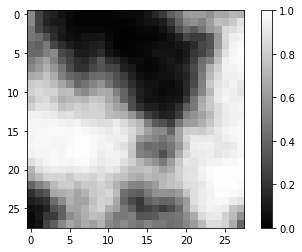

In [ ]:
plt.figure()
plt.imshow(pe.create_image().squeeze().numpy(), cmap='gist_gray', vmin=0, vmax=1)
plt.colorbar()

In [ ]:
perlin_transform = transforms.Compose([
                                    Perlin(saturation=20, p=0.09), 
])

train_dataset.transform = perlin_transform

channels = [8,16,32]
kernel_sizes = [3,3,3]
strides = [2,2,2]
paddings = [1,1,0]
dropout_probabilities = [0.5,0.5]

Nhs = [128, 16]

pnet = DC_net(channels=channels, kernel_sizes=kernel_sizes, strides=strides, paddings=paddings,
             Nhs=Nhs, No=11, dropouts_probabilities=dropout_probabilities).to(device)

print(pnet)

optimizer = optim.Adam(pnet.parameters(),lr=0.001,weight_decay=0.0001)

loss_function = nn.CrossEntropyLoss()

train_batch_size = 256
val_batch_size = 256

patience = 40

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=0)


nature = Evolver_es(patience=patience,net=pnet,optimizer=optimizer,loss_function=loss_function,
                    train_dataloader=train_dataloader,val_dataloader=val_dataloader, checkpoint=True)

Network initialized
DC_net(
  (conv_layers): Sequential(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_act1): ReLU()
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_act2): ReLU()
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (conv_act3): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin_layers): Sequential(
    (dropout1): Dropout(p=0.5, inplace=False)
    (lin1): Linear(in_features=288, out_features=128, bias=True)
    (lin_act1): ReLU()
    (dropout2): Dropout(p=0.5, inplace=False)
    (lin2): Linear(in_features=128, out_features=16, bias=True)
    (lin_act2): ReLU()
  )
  (out): Linear(in_features=16, out_features=11, bias=True)
  (o_act): Identity()
)


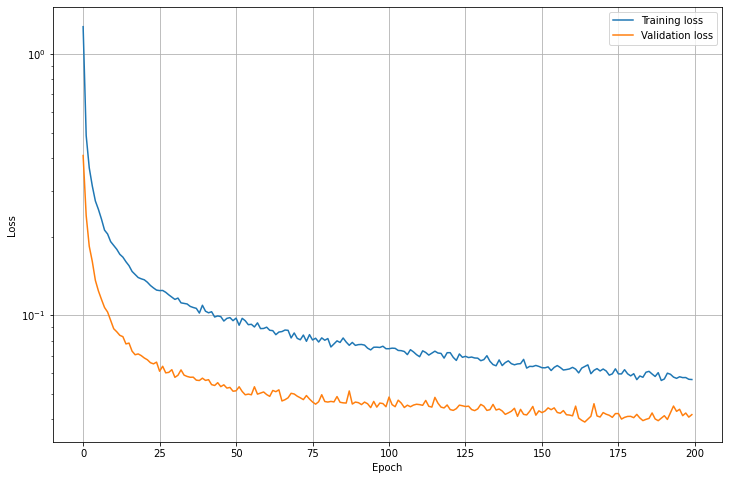

Average traininig  loss in the last 10 epochs: 0.0580
Average validation loss in the last 10 epochs: 0.0421


In [ ]:
nature.evolve(200,verbose= False)

nature.plot_losses()

In [ ]:
mse_test(nature, test_dataset)

In [ ]:
evaluate_net(pnet,test_dataset)

(     0     1     2     3    4    5    6     7    8    9
 0  975     1     0     0    1    0    1     1    1    0
 1    0  1130     1     1    0    0    2     1    0    0
 2    1     0  1025     1    0    0    1     3    1    0
 3    0     0     1  1002    0    2    0     1    4    0
 4    0     0     0     0  977    0    1     0    0    4
 5    3     0     0     6    0  880    2     0    1    0
 6    5     3     0     0    1    4  943     0    2    0
 7    0     1     4     0    1    0    0  1018    1    3
 8    1     0     2     1    0    0    0     3  963    4
 9    2     2     0     1    6    5    0     7    1  985,
 0.9898)

In [ ]:
pnet.eval()
nm = NeuronMaximizer(pnet,pnet.out,10,optimizer_params={'lr': 0.1, 'weight_decay': 0.01})
nm.optimize(100)

In [ ]:
y = torch.softmax(pnet(torch.sigmoid(nm.input_img).unsqueeze(0)), dim=1)

y = y.squeeze().detach().cpu().numpy()

for i,yv in enumerate(y):
  print(f'{i}: {yv}')

This approach is interesting, but networks are very slow to train

## K fold

In [ ]:
class KFoldCrossValidator(object):
  '''
  Performs a k fold cross validation on a specific set of hyperparameters

  Args:
    k: int, number of folds
    n_runs: int or None: if n_runs < k, only the first n_runs will be performed.
            This is a quick workaround to speed up the hyperparameter optimization process
    shuffle: bool: if true data is shuffled before the splitting in k folds
    all_train_dataset: Dataset with train and validation data that will be split in folds

    net_type: user defined class
    net_params: dictionary or list of the arguments for net_type.__init__

    optimizer_type: e.g. optim.Adam
    optimizer_params: dictionary or list of the arguments of the optimizer (except net.parameters())

    loss_function
    train_batch_size: int, default 256

    evolver_type: e.g. Evolver or Evolver_es
    evolver_additional_params: dictionary with additional parameters for the evolver,
      e.g. if evolver_type = Evolver_es, the additional parameter 'patience' must be provided
  '''

  def __init__(self, k, n_runs=None, shuffle=False, all_train_dataset=None, net_type=None, net_params=None,
               optimizer_type=None, optimizer_params=None, loss_function=None,
               train_batch_size=256, evolver_type=None, evolver_additional_params={}):

    self.splitter = KFold(k,shuffle=shuffle)

    self.all_train_dataset = all_train_dataset

    self.net_type = net_type
    self.net_params = net_params
    self.optimizer_type = optimizer_type
    self.optimizer_params = optimizer_params

    self.train_batch_size = train_batch_size

    self.loss_function = loss_function

    self.evolver_type = evolver_type
    self.evolver_additional_params = evolver_additional_params

    self.evolvers = []

    # set up the object with k (or n_runs) evolvers
    i = 0
    for train_idx, val_idx in self.splitter.split(list(range(len(self.all_train_dataset)))):
      # datasets
      train_dataset = Subset(self.all_train_dataset, train_idx)
      val_dataset = Subset(self.all_train_dataset, val_idx)

      # dataloaders
      train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=0)
      val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=0)

      # net
      if type(self.net_params) == dict:
        net = self.net_type(**self.net_params)
      else:
        net = self.net_type(*self.net_params)

      # optimizer
      if type(self.optimizer_params) == dict:
        optimizer = self.optimizer_type(net.parameters(),**self.optimizer_params)
      else:
        optimizer = self.optimizer_type(net.parameters(),*self.optimizer_params)

      # evolver
      evolver = self.evolver_type(net=net,optimizer=optimizer,loss_function=loss_function,
                                  train_dataloader=train_dataloader,val_dataloader=val_dataloader, **self.evolver_additional_params)

      self.evolvers.append(evolver)

      i += 1
      if n_runs is not None and i >= n_runs:
        break


  def run(self,num_epochs,loss_sample_size=10, prune_thr=None):
    '''
    Args:
      num_epochs: maximum number of epochs for each fold
      loss_sample_size: number of epochs for computing the average train and val losses, default 10
      prune_thr: folat or None: if one of the final validation losses is > prune thr, the run is interrupted raising a ValueError
    '''
    for k,evolver in enumerate(self.evolvers):
      # move the net to the GPU
      evolver.net.to(device)
      evolver.evolve(num_epochs)
      # move the net back to free the GPU
      evolver.net.cpu()
      if prune_thr is not None and k < len(self.evolvers)/2 and evolver.val_loss_log[-1] > prune_thr:
        print(f'Trial pruned: val loss was {evolver.val_loss_log[-1]}')
        raise ValueError


      # print avg train and val loss
      print(np.mean(evolver.train_loss_log[-loss_sample_size:]), np.mean(evolver.val_loss_log[-loss_sample_size:]))

    avg_train_loss = np.mean([np.mean(e.train_loss_log[-loss_sample_size:]) for e in self.evolvers])
    avg_val_loss   = np.mean([np.mean(e.val_loss_log[-loss_sample_size:]) for e in self.evolvers])
    
    return avg_train_loss, avg_val_loss
    

  def view(self,idx):
    '''
    Plot losses and net output
    Args:
      idx: int in [0, k) or 'best', index of the evolver to view
    '''
    if idx == 'best':
      idx = np.argmin([e.best_vl for e in self.evolvers])
      print(f'Best evolver is number {idx} with minimum validation loss {self.evolvers[idx].best_vl}')

    self.evolvers[idx].plot_losses()

In [ ]:
### testing

k = 3

# net params
net_type = DC_net

net_params = {'channels': [8,16,32], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [1,1,0],
              'dropouts_probabilities': [0.5,0.5], 'Nhs': [128, 16]}

# optimizer params
optimizer_type = optim.Adam
optimizer_params = {'lr': 0.001}

loss_function = nn.CrossEntropyLoss()

train_batch_size = 256

evolver_type = Evolver_es
evolver_additional_params = {'patience': 10}


# KFold

kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, evolver_type=evolver_type, evolver_additional_params=evolver_additional_params)

kf.run(100)

## Hyperparameter optimization with optuna

In [ ]:
global df
df = None

In [ ]:
k = 5
n_runs = 2

name = 'classification/optuna_search3'

if os.path.exists(f'{name}.csv'):
  df = pd.read_csv(f'{name}.csv')

net_type = DC_net
optimizer_type = optim.Adam

loss_function = nn.CrossEntropyLoss()

train_batch_size = 256

evolver_type = Evolver_es
evolver_additional_params = {'patience': 10} # no checkpoint to speed up the training

def objective(trial):

  global df

  # sample hypermarameters
  
  # convolutional layers part
  n_c_layers = trial.suggest_int('ncl', 2, 4)
  
  channels = []
  kernel_sizes = []
  strides = []
  paddings = []

  for j in range(n_c_layers):
    channels.append(trial.suggest_int(f'ch{j+1}', 4, 8*2**j))
    kernel_sizes.append(trial.suggest_int(f'ks{j+1}', 2, 6))
    strides.append(trial.suggest_int(f'stride{j+1}', 1, 4))
    paddings.append(trial.suggest_int(f'padding{j+1}', 0, 1))


  # linear layers part
  p1 = trial.suggest_float('p1', 0, 0.7)
  p2 = trial.suggest_float('p2', 0, 0.7)
  Nh1 = trial.suggest_int('Nh1', 16, 256)
  Nh2 = trial.suggest_int('Nh2', 4, 128)

  # optimizer part
  lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
  weight_decay = trial.suggest_float('weight_decay', 1e-7,1e-1, log=True)

  net_params = {'channels': channels, 'kernel_sizes': kernel_sizes, 'strides': strides, 'paddings': paddings,
              'dropouts_probabilities': [p1,p2], 'Nhs': [Nh1, Nh2]}
  
  optimizer_params = {'lr': lr, 'weight_decay': weight_decay}


  start_time = time.time()
  try:
    kf = KFoldCrossValidator(k, n_runs=n_runs, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                          optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                          train_batch_size=train_batch_size, evolver_type=evolver_type, evolver_additional_params=evolver_additional_params)

    avg_tr_loss, avg_val_loss = kf.run(100)
  except KeyboardInterrupt:
    raise KeyboardInterrupt
  except:
    raise optuna.TrialPruned() # to stop trials that produce invalid nets

  
  train_time = (time.time() - start_time)/(60*n_runs) # avg train time in minutes

  print(f'{avg_tr_loss = }, {avg_val_loss = }, {train_time = } min')

  # dictionary with all the hyperparameters and performance of the net
  hyper_dict = dict(**net_params, **optimizer_params, **{'avg_tr_loss': avg_tr_loss, 'avg_val_loss': avg_val_loss, 'train_time': train_time})

  if df is None:
    df = pd.DataFrame([], columns=list(hyper_dict.keys()))

  df.loc[len(df)] = hyper_dict

  df.to_csv(f'{name}.csv', index=False)

  # add a time penalty as regularizer
  time_penalty = 1e-5

  return np.mean([e.best_vl for e in kf.evolvers]) + time_penalty*train_time


study = optuna.create_study(study_name=name, storage=f'sqlite:///{name}.db', load_if_exists=True)

In [ ]:
study.optimize(objective, n_trials=50)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

### Analyze the study

In [ ]:
study.trials_dataframe()[['params_ncl', 'state']]

,params_ncl,state
0,2,PRUNED
1,4,PRUNED
2,4,PRUNED
3,2,COMPLETE
4,2,PRUNED
5,3,PRUNED
6,4,PRUNED
7,4,PRUNED
8,4,PRUNED
9,4,PRUNED


In [ ]:
np.sum(study.trials_dataframe()['state'] == 'PRUNED')

28

In [ ]:
fig = optuna.visualization.plot_contour(study,params=['lr', 'weight_decay'])
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show(renderer='colab')

In [ ]:
fig = optuna.visualization.plot_parallel_coordinate(study, params=['Nh1', 'Nh2', 'p1', 'p2'])
fig.show(renderer='colab')

In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show(renderer='colab')

## Best net

### Training with the best hyperparameters

In [ ]:
study.best_params

{'Nh1': 129,
 'Nh2': 69,
 'ch1': 4,
 'ch2': 15,
 'ch3': 19,
 'ks1': 3,
 'ks2': 3,
 'ks3': 4,
 'lr': 0.0009484803741192007,
 'ncl': 3,
 'p1': 0.472604419965323,
 'p2': 0.6959952214334578,
 'padding1': 0,
 'padding2': 1,
 'padding3': 1,
 'stride1': 3,
 'stride2': 1,
 'stride3': 2,
 'weight_decay': 9.391795876487639e-06}

In [ ]:
channels = [4,15,19]
kernel_sizes = [3,3,4]
strides = [3,1,2]
paddings = [0,1,1]

dropout_probabilities = [0.4726,0.6960]
Nhs = [129, 69]

dnet = DC_net(dropouts_probabilities=dropout_probabilities,channels=channels, kernel_sizes=kernel_sizes, strides=strides, paddings=paddings,
             Nhs=Nhs).to(device)

print(dnet)

optimizer = optim.Adam(dnet.parameters(),lr=9.485e-4,weight_decay=9.392e-6)

loss_function = nn.CrossEntropyLoss()

train_batch_size = 256
val_batch_size = 256

patience = 10

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=0)


nature = Evolver_es(patience=patience,net=dnet,optimizer=optimizer,loss_function=loss_function,
                    train_dataloader=train_dataloader,val_dataloader=val_dataloader, checkpoint=True)

Network initialized
DC_net(
  (conv_layers): Sequential(
    (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(3, 3))
    (conv_act1): ReLU()
    (conv2): Conv2d(4, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_act2): ReLU()
    (conv3): Conv2d(15, 19, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_act3): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin_layers): Sequential(
    (dropout1): Dropout(p=0.4726, inplace=False)
    (lin1): Linear(in_features=304, out_features=129, bias=True)
    (lin_act1): ReLU()
    (dropout2): Dropout(p=0.696, inplace=False)
    (lin2): Linear(in_features=129, out_features=69, bias=True)
    (lin_act2): ReLU()
  )
  (out): Linear(in_features=69, out_features=10, bias=True)
  (o_act): Identity()
)


Checkpointing back to epoch 69



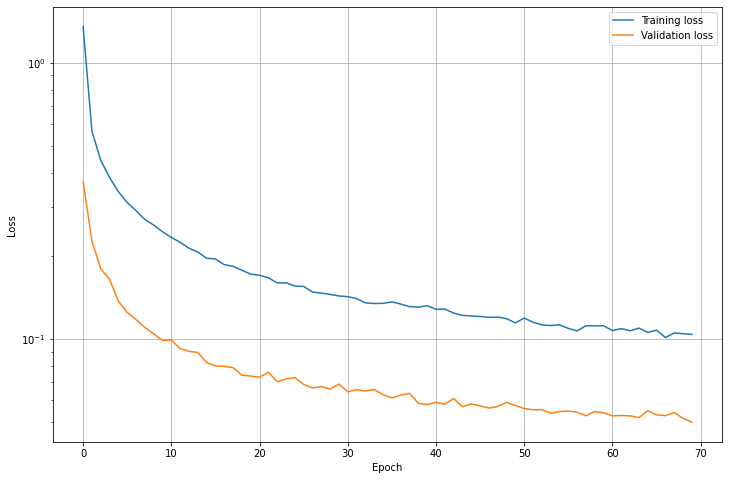

Average traininig  loss in the last 10 epochs: 0.1062
Average validation loss in the last 10 epochs: 0.0527


In [ ]:
nature.evolve(100,verbose= False)

nature.plot_losses()

### Test and visualization

In [ ]:
mse_test(nature, test_dataset)

0.9901547841727734

In [ ]:
evaluate_net(dnet,test_dataset)

(     0     1     2    3    4    5    6     7    8    9
 0  975     0     0    0    0    0    3     1    1    0
 1    0  1129     3    0    0    1    1     1    0    0
 2    1     1  1021    1    0    0    1     4    3    0
 3    0     0     3  998    0    3    0     3    2    1
 4    0     0     1    0  969    0    6     1    0    5
 5    2     0     0    2    0  885    2     1    0    0
 6    2     2     0    0    1    4  949     0    0    0
 7    2     1     9    3    0    0    0  1008    1    4
 8    4     0     3    2    1    2    1     2  957    2
 9    1     3     0    3    9    5    0     4    2  982,
 0.9873)

In [ ]:
dnet.eval()
nm = NeuronMaximizer(dnet,dnet.out,9,optimizer_params={'lr': 0.1, 'weight_decay': 0.01})
nm.optimize(100)

In [ ]:
y = torch.softmax(dnet(torch.sigmoid(nm.input_img).unsqueeze(0)), dim=1)

y = y.squeeze().detach().cpu().numpy()

for i,yv in enumerate(y):
  print(f'{i}: {yv}')

#### Feeding perlin noise to the net

In [ ]:
pe = Perlin(saturation=20,pnoise_kwargs={'octaves': 2, 'persistence': 0.5, 'lacunarity': 2})

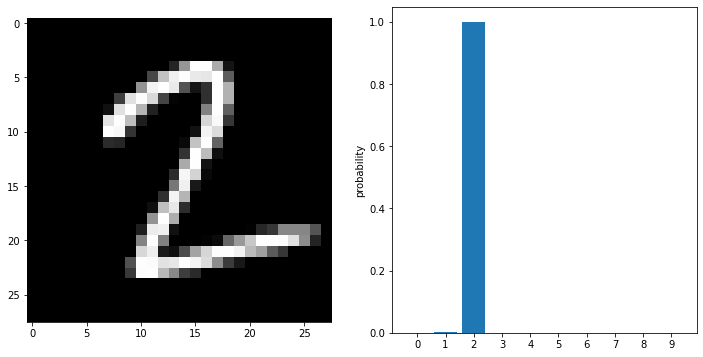

In [ ]:
img = test_dataset[837][0]
# img = pe.create_image()

y = torch.softmax(dnet(img.unsqueeze(0).to(device)), dim=1)

y = y.squeeze().detach().cpu().numpy()

fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].imshow(img.squeeze().cpu().numpy(), cmap='gist_gray', vmax=1, vmin=0)
ax[1].bar(np.arange(10), y)
ax[1].set_xticks(np.arange(10))
ax[1].set_ylabel('probability')

plt.show()

In [ ]:
torch.save(dnet.state_dict(),'classification/best_net.pth')